In [1]:
from scvi.criticism import PosteriorPredictiveCheck as PPC
from ppc_plot_utils import PPCPlot
from scipy.sparse import issparse
import numpy as np
import pandas as pd
import scvi
import scanpy as sc

/home/zhoujian/anaconda3/envs/scvi-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("/home/zhoujian/human/model3/adata_processed.h5ad")
vae = scvi.model.SCVI.load("/home/zhoujian/human/model2/cell_type_scvi_model", adata=adata)
lvae = scvi.model.SCANVI.load("/home/zhoujian/human/model3/cell_type_scanvi_model", adata=adata)
lvae2 = scvi.model.SCANVI.load("/home/zhoujian/human/model3/cell_type_scanvi_model2", adata=adata)

INFO     File /home/zhoujian/human/model2/cell_type_scvi_model/model.pt already downloaded                         
INFO     File /home/zhoujian/human/model3/cell_type_scanvi_model/model.pt already downloaded                       
INFO     File /home/zhoujian/human/model3/cell_type_scanvi_model2/model.pt already downloaded                      


In [3]:
counts_src = adata.layers["counts"] if "counts" in adata.layers else adata.X

# 2) 稀疏->稠密（注意：.toarray()，不是 .A）
if issparse(counts_src):
    counts_dense = counts_src.toarray()
else:
    counts_dense = np.asarray(counts_src)

# 若是浮点但其实为整数，转成 int（PPC 需要原始计数）
if np.issubdtype(counts_dense.dtype, np.floating):
    if np.allclose(counts_dense, np.rint(counts_dense)):
        counts_dense = np.rint(counts_dense).astype(np.int32)
# 3) 放到新层并跑 PPC
adata.layers["counts_ppc"] = counts_dense

In [4]:
ppc = scvi.criticism.PosteriorPredictiveCheck(
    lvae.adata,
    models_dict={"SCANVI": lvae},
    count_layer_key="counts_ppc",   # 你放原始整数计数的层
    n_samples=12,                   # ↑ 稳定
)

ppc.differential_expression(
    de_groupby="cell type",
    de_method="wilcoxon",
    p_val_thresh=0.05,              # 收紧阈值，降低PR基线
    cell_scale_factor=1e4,          # 和scanpy常用一致
)
ppc.coefficient_of_variation("features")

model=SCANVI | metric=cv_cell | n_cells=24291:
Mean Absolute Error=0.77,
Pearson correlation=0.98,
Spearman correlation=0.93,
R^2=0.95,



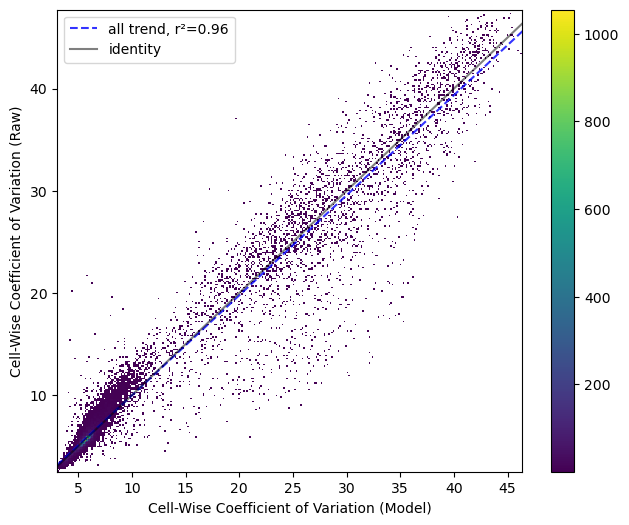

In [5]:
import matplotlib.pyplot as plt
ppc_plt = PPCPlot(ppc)

ax = ppc_plt.plot_cv(
    model_name="SCANVI",
    cell_wise=True,
    plt_type="hist2d",
)
fig = ax.figure if ax is not None else plt.gcf()

# fig.savefig("fig/ppc_cv_scvi.svg", bbox_inches="tight")
# fig.savefig("fig/ppc_cv_scvi.pdf", bbox_inches="tight")

/home/zhoujian/human/ppc_plot_utils.py:262: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(model_de_metrics, showfliers = False, width=.6, palette=sns.color_palette("pastel"))
/home/zhoujian/human/ppc_plot_utils.py:263: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(model_de_metrics, size=4, color=".3", linewidth=1, palette=sns.color_palette("pastel"))
/home/zhoujian/human/ppc_plot_utils.py:263: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.stripplot(model_de_metrics, size=4, color=".3", linewidth=1, palette=sns.color_palette("pastel"))


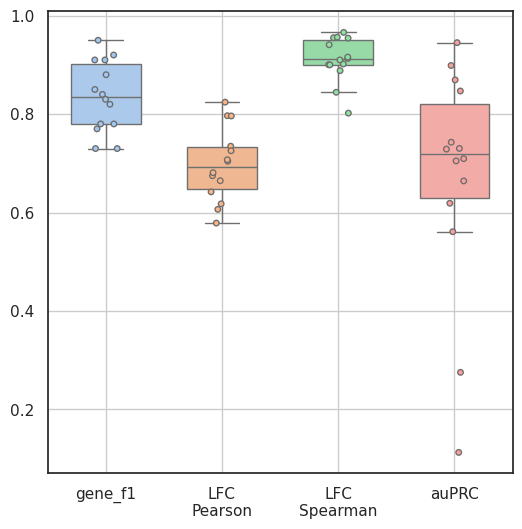

In [19]:
key = "diff_exp" if "diff_exp" in ppc.metrics else "differential_expression"

backup = copy.deepcopy(ppc.metrics[key])

def should_drop(col: str) -> bool:
    c = col.lower().replace(" ", "")
    return (
        c in {"n_cell", "n_cells", "nobs", "n_obs"}
        or "n_cell" in c
        or "ncells" in c
        or "n_obs" in c
    )

def drop_cols_nested(obj):
    if isinstance(obj, pd.DataFrame):
        drop_cols = [c for c in obj.columns if should_drop(c)]
        return obj.drop(columns=drop_cols, errors="ignore")
    elif isinstance(obj, dict):
        return {k: drop_cols_nested(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        t = [drop_cols_nested(v) for v in obj]
        return type(obj)(t)
    else:
        return obj

ppc.metrics[key] = drop_cols_nested(ppc.metrics[key])

ppc_plt = PPCPlot(ppc)
ax = ppc_plt.plot_diff_exp(
    "SCANVI",
    plot_kind="summary_box_with_obs",
)


# ppc.metrics[key] = backup
fig = ax.figure if ax is not None else plt.gcf()

# fig.savefig("fig/ppc_diff_scvi.svg", bbox_inches="tight")
# fig.savefig("fig/ppc_diff_scvi.pdf", bbox_inches="tight")

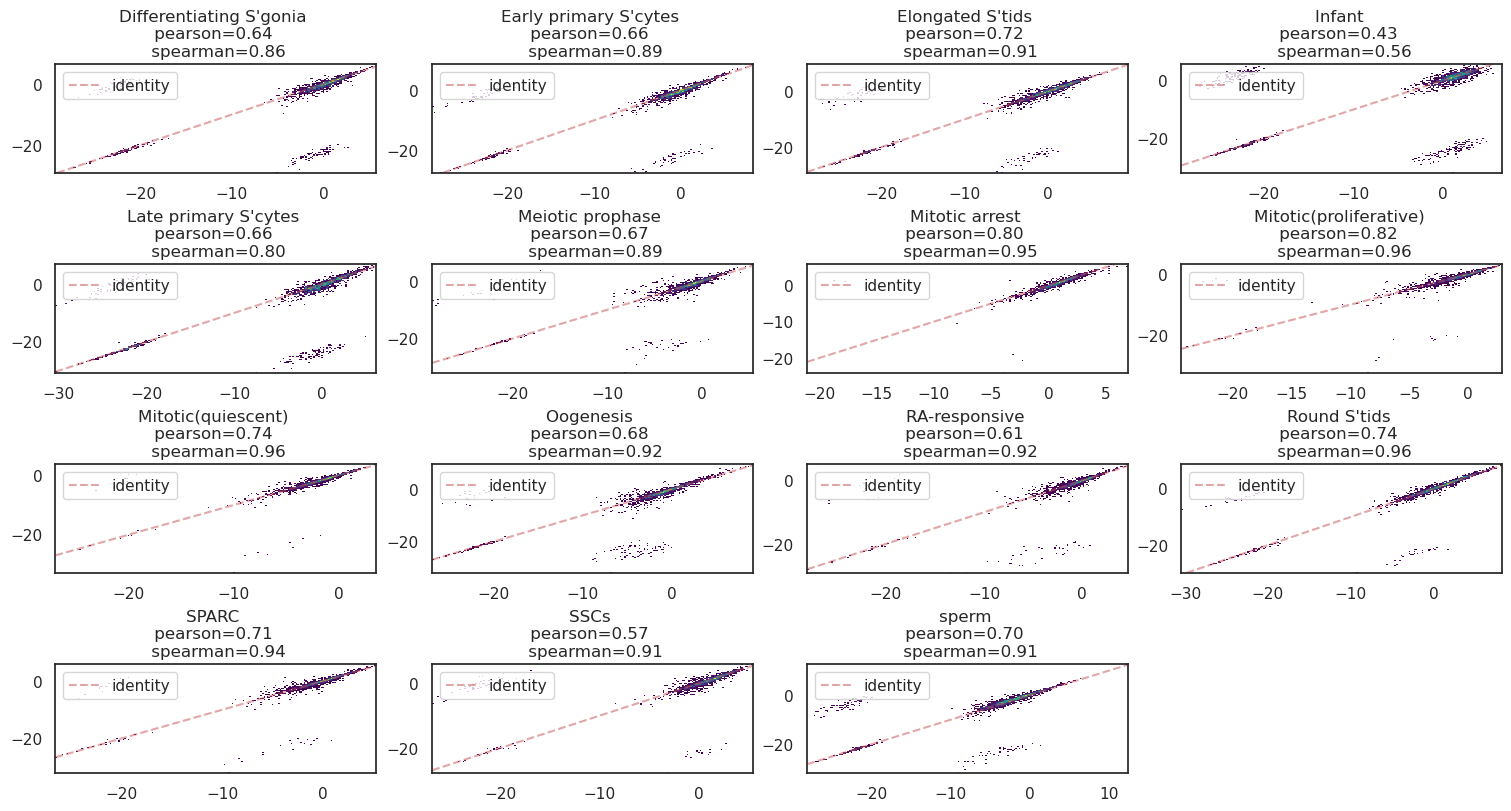

In [53]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCANVI",
    plot_kind="lfc_scatterplots",
)
# fig_path = f'{temp_fig_dir}/de_per_group_lfc_scatter.svg'
# plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [24]:
import anndata
import warnings
import matplotlib
from typing import Optional
from sparse import SparseArray
adata_de = anndata.AnnData(X=ppc.raw_counts.to_scipy_sparse().tocsr().copy(), obs=ppc.adata.obs, var=ppc.adata.var)
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_de, "cell type", use_raw=False, method="t-test")

In [39]:
adata_approx = anndata.AnnData(X=adata_de.X, obs=adata_de.obs, var=adata_de.var)
model = "SCANVI"
one_sample = ppc.samples_dataset[model].isel(samples=0)
# overwrite X with the posterior predictive sample
one_sample_data = (
    one_sample.data.to_scipy_sparse().tocsr()
    if isinstance(one_sample.data, SparseArray)
    else one_sample
)
adata_approx.X = one_sample_data.copy()
sc.pp.normalize_total(adata_approx, target_sum=1e4)
sc.pp.log1p(adata_approx)

# run DE with the imputed normalized data
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    sc.tl.rank_genes_groups(adata_approx, "cell type", use_raw=False, method="t-test")

In [84]:
def _get_top_n_genes_per_group(adata: anndata.AnnData, n_genes: int, var_gene_names_col: Optional[str] = None):
    rgg = adata.uns["rank_genes_groups"]
    rgg_names = pd.DataFrame.from_records(rgg["names"])
    group_to_genes = {}
    for group in rgg_names.columns:
        top_n_gene_ids = rgg_names[group].values[:n_genes]
        if var_gene_names_col is None:
            top_n_gene_names = top_n_gene_ids.tolist()
        else:
            top_n_gene_names = adata.var.loc[top_n_gene_ids][var_gene_names_col].values.tolist()
        group_to_genes[group] = top_n_gene_names
    return group_to_genes

var_names = _get_top_n_genes_per_group(adata_de, 2, "feature_name")

In [31]:
import re
import pandas as pd

def get_top_n_skip_mt(
    adata, n=2, display_col="feature_name", key="rank_genes_groups",
    also_exclude_patterns=(r"^MT-",),           
):
    # 1) 取排名结果 -> DataFrame
    names = adata.uns[key]["names"]
    if hasattr(names, "dtype") and getattr(names.dtype, "names", None):
        df = pd.DataFrame({g: names[g] for g in names.dtype.names})
    else:
        df = pd.DataFrame(names)

    if display_col in adata.var:
        disp_series = adata.var[display_col].astype(str)
        disp_series.index = adata.var_names
    else:
        disp_series = pd.Series(adata.var_names.astype(str), index=adata.var_names)
    disp_map = disp_series.to_dict()

    exclude_ids = set()
    if "mt" in adata.var:
        exclude_ids |= set(adata.var_names[adata.var["mt"] == True])

    rgx = re.compile("|".join(also_exclude_patterns), flags=re.I) if also_exclude_patterns else None

    def should_exclude(vn):
        if vn in exclude_ids:
            return True
        if rgx is not None:
           
            if rgx.match(str(vn)):
                return True
            disp = disp_map.get(vn, "")
            if rgx.match(str(disp)):
                return True
        return False
    out = {}
    for g in df.columns:
        picks = []
        for vn in df[g].tolist():
            vn = str(vn)
            if should_exclude(vn):
                continue
            picks.append(vn)
            if len(picks) == n:
                break
        # 用映射逐个回退：没显示名就用 var_name 本身
        out[g] = [disp_map.get(vn, vn) for vn in picks]
    return out
top2_skip_mt = get_top_n_skip_mt(
    adata_de, n=2, display_col="feature_name",
    also_exclude_patterns=(r"^MT-",)  # 若要再排除核糖体： (r"^MT-", r"^RP[SL]\d")
)
top2_skip_mt


{'Mitotic(proliferative)': ['POU5F1', 'RPS4X'],
 'Mitotic(quiescent)': ['POU5F1', 'RPS4X'],
 'Meiotic prophase': ['PAGE2B', 'B2M'],
 'SPARC': ['RPL10', 'TMSB10'],
 'RA-responsive': ['ANHX', 'SMS'],
 'Oogenesis': ['ZP3', 'FIGLA'],
 'Mitotic arrest': ['DCAF4L1', 'HSP90AB1'],
 'SSCs': ['RUNX1', 'SDK1'],
 "Differentiating S'gonia": ['VCX', 'TKTL1'],
 "Early primary S'cytes": ['SMC1B', 'VCX'],
 "Late primary S'cytes": ['SHCBP1L', 'SPINK2'],
 "Round S'tids": ['SHCBP1L', 'ZPBP'],
 "Elongated S'tids": ['PRM2', 'MLF1'],
 'sperm': ['PRM2', 'GLUL']}

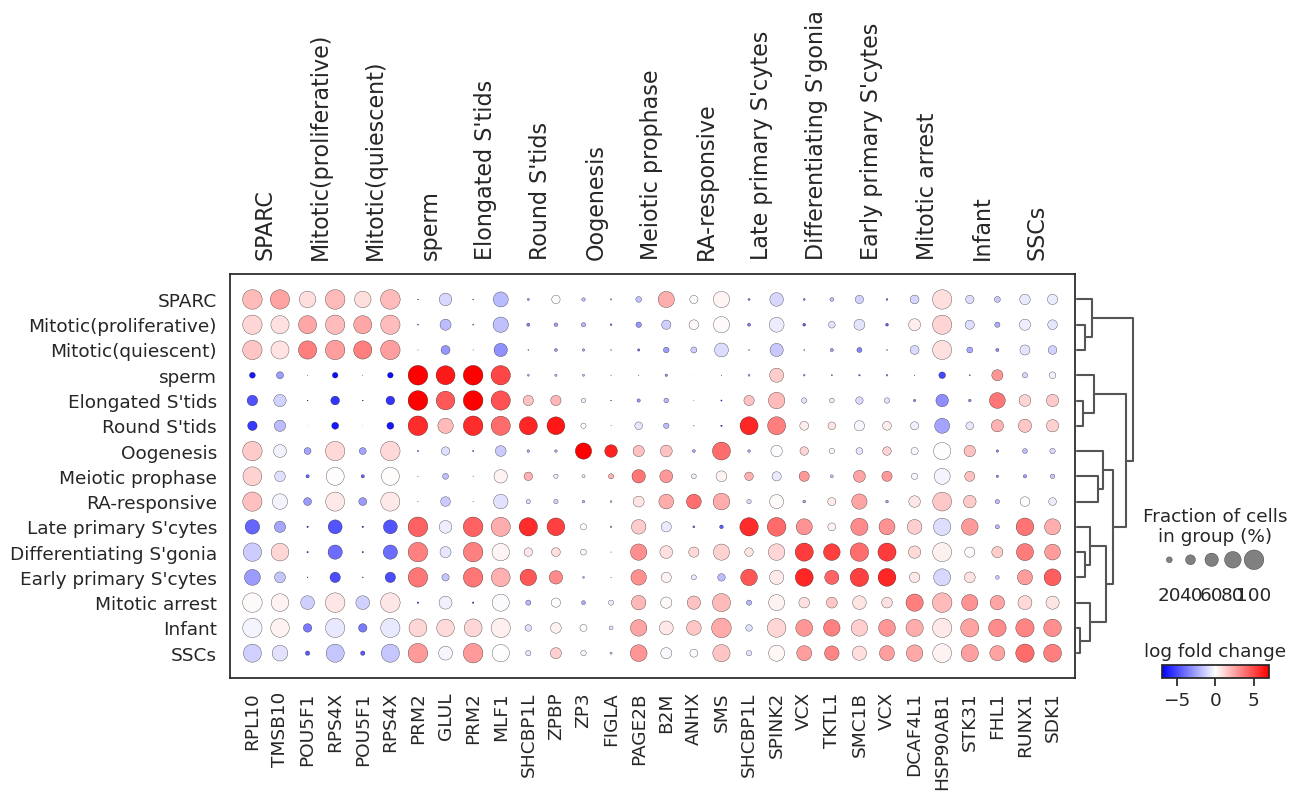

In [90]:
fig_name = "approx.svg"
with plt.rc_context({'font.size': 16}):
    sc.pl.rank_genes_groups_dotplot(
        adata_approx,
        values_to_plot="logfoldchanges",
        vmax=7,
        vmin=-7,
        cmap="bwr",
        dendrogram=True,
        gene_symbols="feature_name",
        var_names=top2_skip_mt,
        save=fig_name,
    )

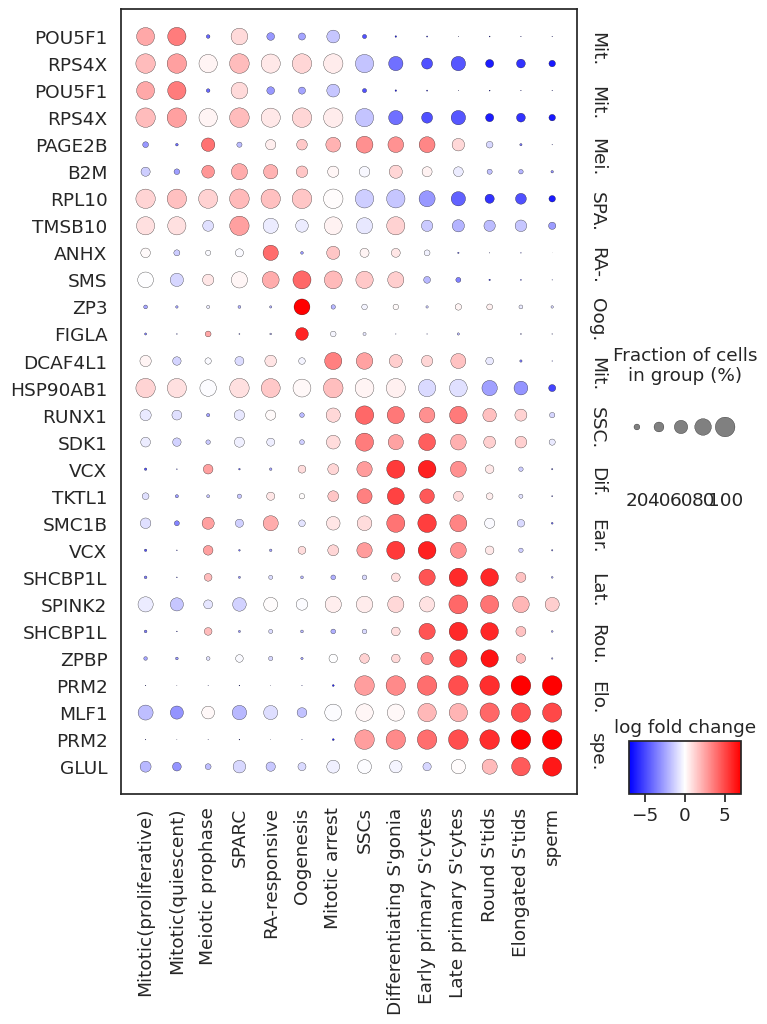

In [40]:
fig_name = "approx.pdf"
h = max(4, 0.35 * sum(len(v) for v in top2_skip_mt.values()))

with plt.rc_context({'font.size': 16}):
    sc.pl.rank_genes_groups_dotplot(
        adata_approx,
        var_names=top2_skip_mt,
        values_to_plot="logfoldchanges",
        gene_symbols="feature_name",
        cmap="bwr", vmin=-7, vmax=7,
        swap_axes=True,          # 竖排
        dendrogram=False,        # ← 关闭顶部树状图
        figsize=(8, h),
        save=fig_name,
        # grid=False,            # 如果连背景网格也不想要，顺便关掉
    )


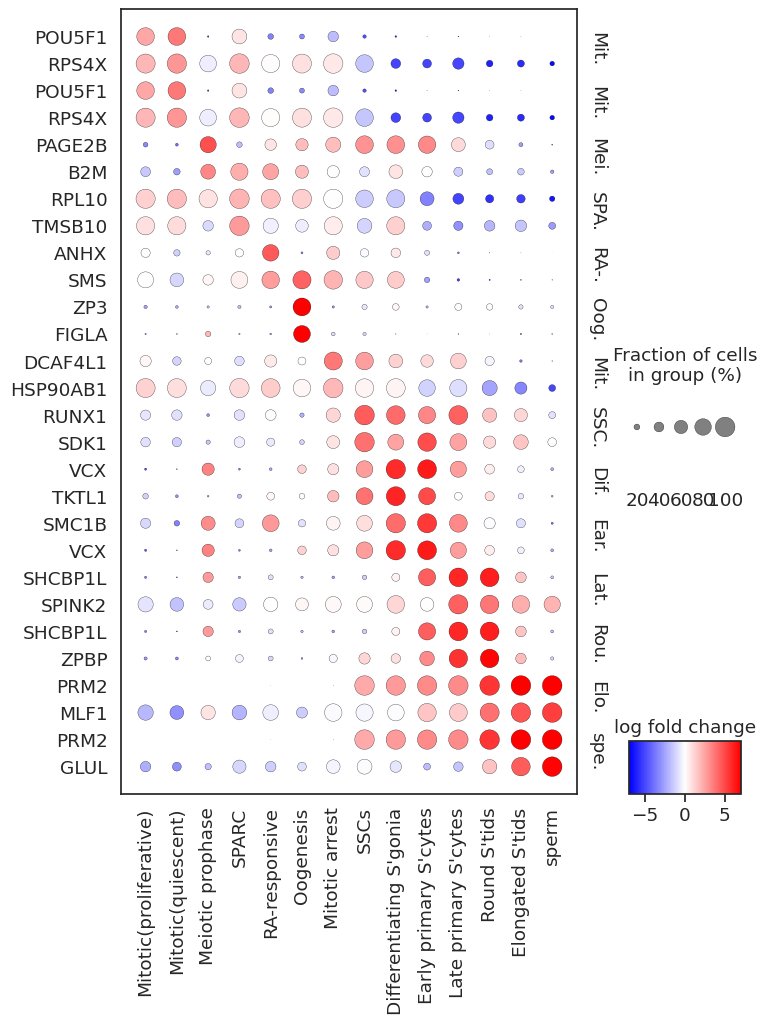

In [34]:
fig_name = "approx.pdf"
h = max(4, 0.35 * sum(len(v) for v in top2_skip_mt.values()))

with plt.rc_context({'font.size': 16}):
    sc.pl.rank_genes_groups_dotplot(
        adata_de,
        var_names=top2_skip_mt,
        values_to_plot="logfoldchanges",
        gene_symbols="feature_name",
        cmap="bwr", vmin=-7, vmax=7,
        swap_axes=True,          # 竖排
        dendrogram=False,        # ← 关闭顶部树状图
        figsize=(8, h),
        save=fig_name,
        # grid=False,            # 如果连背景网格也不想要，顺便关掉
    )